
--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...

 --- marginalized kernel matrix of size 183 built in 440.4844558238983 seconds ---

gram matrix with parameters {'p_quit': 0.1} is: 
[[0.0287062  0.0124634  0.00444444 ... 0.00606061 0.00606061 0.00606061]
 [0.0124634  0.01108958 0.00333333 ... 0.00454545 0.00454545 0.00454545]
 [0.00444444 0.00333333 0.0287062  ... 0.00819912 0.00819912 0.00975875]
 ...
 [0.00606061 0.00454545 0.00819912 ... 0.02846735 0.02836907 0.02896354]
 [0.00606061 0.00454545 0.00819912 ... 0.02836907 0.02831424 0.0288712 ]
 [0.00606061 0.00454545 0.00975875 ... 0.02896354 0.0288712  0.02987915]]


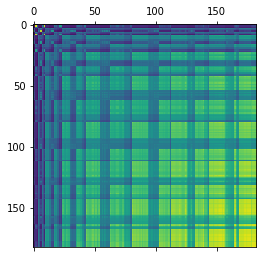


 --- marginalized kernel matrix of size 183 built in 429.7083742618561 seconds ---

gram matrix with parameters {'p_quit': 0.2} is: 
[[0.06171557 0.03856471 0.01777778 ... 0.02424242 0.02424242 0.02424242]
 [0.03856471 0.03579176 0.01333333 ... 0.01818182 0.01818182 0.01818182]
 [0.01777778 0.01333333 0.06171557 ... 0.02994207 0.02994207 0.03262072]
 ...
 [0.02424242 0.01818182 0.02994207 ... 0.07442109 0.07434207 0.07383563]
 [0.02424242 0.01818182 0.02994207 ... 0.07434207 0.07430377 0.07376068]
 [0.02424242 0.01818182 0.03262072 ... 0.07383563 0.07376068 0.07366354]]


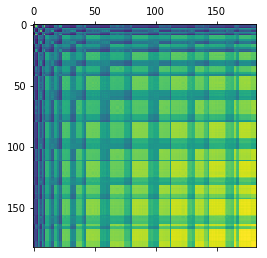


 --- marginalized kernel matrix of size 183 built in 430.415020942688 seconds ---

gram matrix with parameters {'p_quit': 0.30000000000000004} is: 
[[0.09803909 0.07202114 0.04       ... 0.05454545 0.05454545 0.05454545]
 [0.07202114 0.06853421 0.03       ... 0.04090909 0.04090909 0.04090909]
 [0.04       0.03       0.09803909 ... 0.06368916 0.06368916 0.06678704]
 ...
 [0.05454545 0.04090909 0.06368916 ... 0.12892852 0.12891455 0.12734365]
 [0.05454545 0.04090909 0.06368916 ... 0.12891455 0.12892664 0.12733207]
 [0.05454545 0.04090909 0.06678704 ... 0.12734365 0.12733207 0.1261675 ]]


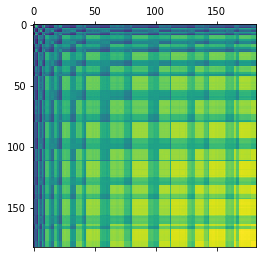


 --- marginalized kernel matrix of size 183 built in 434.5828993320465 seconds ---

gram matrix with parameters {'p_quit': 0.4} is: 
[[0.13888889 0.11120616 0.07111111 ... 0.0969697  0.0969697  0.0969697 ]
 [0.11120616 0.10756609 0.05333333 ... 0.07272727 0.07272727 0.07272727]
 [0.07111111 0.05333333 0.13888889 ... 0.10909713 0.10909713 0.11216176]
 ...
 [0.0969697  0.07272727 0.10909713 ... 0.19178929 0.19182091 0.18963212]
 [0.0969697  0.07272727 0.10909713 ... 0.19182091 0.19186661 0.18966477]
 [0.0969697  0.07272727 0.11216176 ... 0.18963212 0.18966477 0.18786824]]


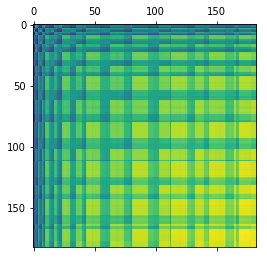


 --- marginalized kernel matrix of size 183 built in 434.108122587204 seconds ---

gram matrix with parameters {'p_quit': 0.5} is: 
[[0.18518519 0.15591398 0.11111111 ... 0.15151515 0.15151515 0.15151515]
 [0.15591398 0.15254237 0.08333333 ... 0.11363636 0.11363636 0.11363636]
 [0.11111111 0.08333333 0.18518519 ... 0.16617791 0.16617791 0.16890214]
 ...
 [0.15151515 0.11363636 0.16617791 ... 0.26386999 0.26391515 0.26158184]
 [0.15151515 0.11363636 0.16617791 ... 0.26391515 0.26396688 0.26162729]
 [0.15151515 0.11363636 0.16890214 ... 0.26158184 0.26162729 0.25964592]]


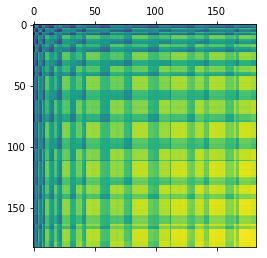


 --- marginalized kernel matrix of size 183 built in 435.4211935997009 seconds ---

gram matrix with parameters {'p_quit': 0.6} is: 
[[0.23809524 0.20664506 0.16       ... 0.21818182 0.21818182 0.21818182]
 [0.20664506 0.20385906 0.12       ... 0.16363636 0.16363636 0.16363636]
 [0.16       0.12       0.23809524 ... 0.2351024  0.2351024  0.23727718]
 ...
 [0.21818182 0.16363636 0.2351024  ... 0.34658956 0.34662512 0.34454945]
 [0.21818182 0.16363636 0.2351024  ... 0.34662512 0.34666325 0.34458505]
 [0.21818182 0.16363636 0.23727718 ... 0.34454945 0.34458505 0.34279503]]


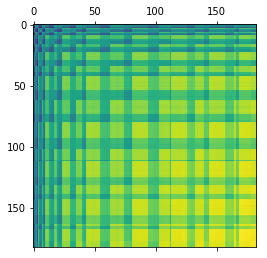


 --- marginalized kernel matrix of size 183 built in 430.830694437027 seconds ---

gram matrix with parameters {'p_quit': 0.7000000000000001} is: 
[[0.2991453  0.26444601 0.21777778 ... 0.2969697  0.2969697  0.2969697 ]
 [0.26444601 0.26246188 0.16333333 ... 0.22272727 0.22272727 0.22272727]
 [0.21777778 0.16333333 0.2991453  ... 0.31614548 0.31614548 0.31765009]
 ...
 [0.2969697  0.22272727 0.31614548 ... 0.44189997 0.44191814 0.44038348]
 [0.2969697  0.22272727 0.31614548 ... 0.44191814 0.44193708 0.44040164]
 [0.2969697  0.22272727 0.31765009 ... 0.44038348 0.44040164 0.43906772]]


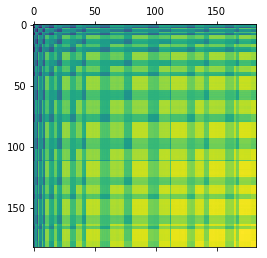


 --- marginalized kernel matrix of size 183 built in 436.9290747642517 seconds ---

gram matrix with parameters {'p_quit': 0.8} is: 
[[0.37037037 0.33093141 0.28444444 ... 0.38787879 0.38787879 0.38787879]
 [0.33093141 0.32983023 0.21333333 ... 0.29090909 0.29090909 0.29090909]
 [0.28444444 0.21333333 0.37037037 ... 0.4096795  0.4096795  0.41049599]
 ...
 [0.38787879 0.29090909 0.4096795  ... 0.55242487 0.55243009 0.5515636 ]
 [0.38787879 0.29090909 0.4096795  ... 0.55243009 0.55243545 0.55156881]
 [0.38787879 0.29090909 0.41049599 ... 0.5515636  0.55156881 0.55081257]]


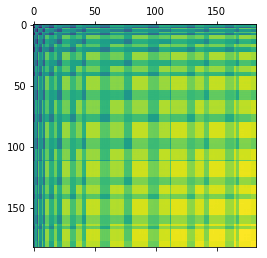


 --- marginalized kernel matrix of size 183 built in 431.67696499824524 seconds ---

gram matrix with parameters {'p_quit': 0.9} is: 
[[0.45454545 0.40839542 0.36       ... 0.49090909 0.49090909 0.49090909]
 [0.40839542 0.40805534 0.27       ... 0.36818182 0.36818182 0.36818182]
 [0.36       0.27       0.45454545 ... 0.51619708 0.51619708 0.51644564]
 ...
 [0.49090909 0.36818182 0.51619708 ... 0.68172189 0.68172233 0.68145294]
 [0.49090909 0.36818182 0.51619708 ... 0.68172233 0.68172277 0.68145338]
 [0.49090909 0.36818182 0.51644564 ... 0.68145294 0.68145338 0.68121781]]


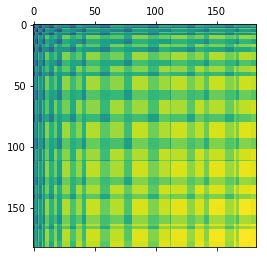


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 2/11070 [00:00<14:22, 12.83it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                            
4. Getting final performances...

best_params_out:  [{'p_quit': 0.30000000000000004}]
best_params_in:  [{'alpha': 3.162277660168379e-06}]
best_val_perf:  18.59885234533721
best_val_std:  2.019904187960319
final_performance:  16.510316179444224
final_confidence:  5.124271966917598
train_performance:  12.421855720688153
train_std:  0.28436829015391896
time to calculate gram matrix:  430.415020942688 s

params                                                train_perf     valid_perf        test_perf            gram_matrix_time
----------------------------------------------------  -------------  ----------------  -----------------  ------------------
{'alpha': '1.00e-10', 'p_quit': 0.1}                  285.42±221.98  7844.31±17451.82  10290.82±20608.46              440.48
{'alpha': '1.00e-10', 'p_quit': 0.2}                  134.14±105.79  2170.99±1735.30   3275.12±7309.69                429.71
{'alpha': '1.00e-10

calculate performance: 100%|██████████| 11070/11070 [07:00<00:00, 40.88it/s]

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.marginalizedKernel import marginalizedkernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = marginalizedkernel
param_grid_precomputed = {'p_quit': np.linspace(0.1, 0.9, 9)}
param_grid = {'alpha': np.logspace(-10, 10, num = 41, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)

In [2]:
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.marginalizedKernel import marginalizedkernel, _marginalizedkernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type', itr = 20)

kernel_train_test(datafile, kernel_file_path, marginalizedkernel, kernel_para, \
    hyper_name = 'p_quit', hyper_range = np.linspace(0.1, 0.9, 9), normalize = False)

# %lprun -f _marginalizedkernel_do \
#     kernel_train_test(datafile, kernel_file_path, marginalizedkernel, kernel_para, \
#     hyper_name = 'p_quit', hyper_range = np.linspace(0.1, 0.9, 9), normalize = False)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

 --- This is a regression problem ---


 #--- calculating kernel matrix when p_quit = 0.1 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- marginalized kernel matrix of size 185 built in 258.76952958106995 seconds ---
[[ 0.0287062   0.0124634   0.00444444 ...,  0.00606061  0.00606061
   0.00606061]
 [ 0.0124634   0.01108958  0.00333333 ...,  0.00454545  0.00454545
   0.00454545]
 [ 0.00444444  0.00333333  0.0287062  ...,  0.00819912  0.00819912
   0.00975875]
 ..., 
 [ 0.00606061  0.00454545  0.00819912 ...,  0.02846735  0.02836907
   0.02896354]
 [ 0.00606061  0.00454545  0.00819912 ...,  0.02836907  0.02831424
   0.0288712 ]
 [ 0.00606061  0.00454545  0.00975875 ...,  0.02896354  0.0288712
   0.02987915]]

 Saving kernel matrix to file...

 Mean performance on train set: 12.186285
With standard deviation: 7.038988

 Mean performance on test s


 Mean performance on train set: 25.808155
With standard deviation: 3.312074

 Mean performance on test set: 24.424089
With standard deviation: 4.951191


  p_quit    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
     0.1      18.0243     6.29247       12.1863      7.03899   258.77
     0.2      18.3376     5.85454       13.9554      7.54407   256.327
     0.3      18.496      5.73492       13.9391      7.95812   255.614
     0.4      19.4491     5.3713        16.2593      6.69358   254.897
     0.5      19.7857     5.55054       17.0181      6.84437   256.757
     0.6      20.1922     5.59122       17.6618      6.56718   256.557
     0.7      21.6614     6.02685       20.5882      5.74601   254.953
     0.8      22.996      6.08347       23.5943      3.80637   252.804
     0.9      24.4241     4.95119       25.8082      3.31207   256.738


In [ ]:
# results

# with y normalization
  p_quit    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
     0.1      18.0192     6.27867       12.1642      6.99821   266.905
     0.2      18.3374     5.84775       13.9376      7.51398   256.288
     0.3      18.4955     5.73774       13.9291      7.9416    254.441
     0.4      19.4498     5.37509       16.2538      6.68378   257.581
     0.5      19.7851     5.55018       17.0142      6.83653   248.562
     0.6      20.1911     5.58951       17.6595      6.56211   249.667
     0.7      21.6606     6.02589       20.5872      5.74395   243.046
     0.8      22.9959     6.08344       23.5941      3.80595   252.36
     0.9      24.424      4.9512        25.8082      3.31202   248.077

# without y normalization
  p_quit    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
     0.1      18.0243     6.29247       12.1863      7.03899   258.77
     0.2      18.3376     5.85454       13.9554      7.54407   256.327
     0.3      18.496      5.73492       13.9391      7.95812   255.614
     0.4      19.4491     5.3713        16.2593      6.69358   254.897
     0.5      19.7857     5.55054       17.0181      6.84437   256.757
     0.6      20.1922     5.59122       17.6618      6.56718   256.557
     0.7      21.6614     6.02685       20.5882      5.74601   254.953
     0.8      22.996      6.08347       23.5943      3.80637   252.804
     0.9      24.4241     4.95119       25.8082      3.31207   256.738

In [2]:
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.marginalizedKernel import marginalizedkernel, _marginalizedkernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type', itr = 20, p_quit = 0.1)

# kernel_train_test(datafile, kernel_file_path, marginalizedkernel, kernel_para, \
#     hyper_name = 'p_quit', hyper_range = np.linspace(0.1, 0.9, 9), normalize = False)

%lprun -f _marginalizedkernel_do \
    kernel_train_test(datafile, kernel_file_path, marginalizedkernel, kernel_para, \
    normalize = False)


 --- This is a regression problem ---


 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- marginalized kernel matrix of size 185 built in 1133.0229969024658 seconds ---
[[ 0.0287062   0.0124634   0.00444444 ...,  0.00606061  0.00606061
   0.00606061]
 [ 0.0124634   0.01108958  0.00333333 ...,  0.00454545  0.00454545
   0.00454545]
 [ 0.00444444  0.00333333  0.0287062  ...,  0.00819912  0.00819912
   0.00975875]
 ..., 
 [ 0.00606061  0.00454545  0.00819912 ...,  0.02846735  0.02836907
   0.02896354]
 [ 0.00606061  0.00454545  0.00819912 ...,  0.02836907  0.02831424
   0.0288712 ]
 [ 0.00606061  0.00454545  0.00975875 ...,  0.02896354  0.0288712
   0.02987915]]

 Saving kernel matrix to file...

 Mean performance on train set: 12.186285
With standard deviation: 7.038988

 Mean performance on test set: 18.024312
With standard deviation: 6.292466


  rmse_test    std_test    rmse_train    std_train    k_time
-----------  ----------  ------------  

In [ ]:
Timer unit: 1e-06 s

Total time: 828.879 s
File: ../pygraph/kernels/marginalizedKernel.py
Function: _marginalizedkernel_do at line 67

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    67                                           def _marginalizedkernel_do(G1, G2, node_label, edge_label, p_quit, itr):
    68                                               """Calculate marginalized graph kernel between 2 graphs.
    69                                               
    70                                               Parameters
    71                                               ----------
    72                                               G1, G2 : NetworkX graphs
    73                                                   2 graphs between which the kernel is calculated.
    74                                               node_label : string
    75                                                   node attribute used as label.
    76                                               edge_label : string
    77                                                   edge attribute used as label.
    78                                               p_quit : integer
    79                                                   the termination probability in the random walks generating step.
    80                                               itr : integer
    81                                                   time of iterations to calculate R_inf.
    82                                                   
    83                                               Return
    84                                               ------
    85                                               kernel : float
    86                                                   Marginalized Kernel between 2 graphs.
    87                                               """
    88                                               # init parameters
    89     17205      12886.0      0.7      0.0      kernel = 0
    90     17205      52542.0      3.1      0.0      num_nodes_G1 = nx.number_of_nodes(G1)
    91     17205      28240.0      1.6      0.0      num_nodes_G2 = nx.number_of_nodes(G2)
    92     17205      15595.0      0.9      0.0      p_init_G1 = 1 / num_nodes_G1 # the initial probability distribution in the random walks generating step (uniform distribution over |G|)
    93     17205      11587.0      0.7      0.0      p_init_G2 = 1 / num_nodes_G2
    94                                           
    95     17205      11663.0      0.7      0.0      q = p_quit * p_quit
    96     17205      10728.0      0.6      0.0      r1 = q
    97                                           
    98                                               # initial R_inf
    99     17205      38412.0      2.2      0.0      R_inf = np.zeros([num_nodes_G1, num_nodes_G2]) # matrix to save all the R_inf for all pairs of nodes
   100                                           
   101                                               # calculate R_inf with a simple interative method
   102    344100     329235.0      1.0      0.0      for i in range(1, itr):
   103    326895     900354.0      2.8      0.1          R_inf_new = np.zeros([num_nodes_G1, num_nodes_G2])
   104    326895    2287346.0      7.0      0.3          R_inf_new.fill(r1)
   105                                           
   106                                                   # calculate R_inf for each pair of nodes
   107   2653464    3667117.0      1.4      0.4          for node1 in G1.nodes(data = True):
   108   2326569    7522840.0      3.2      0.9              neighbor_n1 = G1[node1[0]]
   109   2326569    3492118.0      1.5      0.4              p_trans_n1 = (1 - p_quit) / len(neighbor_n1) # the transition probability distribution in the random walks generating step (uniform distribution over the vertices adjacent to the current vertex)
   110  24024379   27775021.0      1.2      3.4              for node2 in G2.nodes(data = True):
   111  21697810   69471941.0      3.2      8.4                  neighbor_n2 = G2[node2[0]]
   112  21697810   32446626.0      1.5      3.9                  p_trans_n2 = (1 - p_quit) / len(neighbor_n2)    
   113                                           
   114  59095092   52545370.0      0.9      6.3                  for neighbor1 in neighbor_n1:
   115 104193150   92513935.0      0.9     11.2                      for neighbor2 in neighbor_n2:
   116                                           
   117                                                                   t = p_trans_n1 * p_trans_n2 * \
   118  66795868  285324518.0      4.3     34.4                              deltakernel(G1.node[neighbor1][node_label] == G2.node[neighbor2][node_label]) * \
   119  66795868  137934393.0      2.1     16.6                              deltakernel(neighbor_n1[neighbor1][edge_label] == neighbor_n2[neighbor2][edge_label])
   120  66795868  106834143.0      1.6     12.9                          R_inf_new[node1[0]][node2[0]] += t * R_inf[neighbor1][neighbor2] # ref [1] equation (8)
   121                                           
   122    326895    1123677.0      3.4      0.1          R_inf[:] = R_inf_new
   123                                           
   124                                               # add elements of R_inf up and calculate kernel
   125    139656     330283.0      2.4      0.0      for node1 in G1.nodes(data = True):
   126   1264441    1435263.0      1.1      0.2          for node2 in G2.nodes(data = True):                
   127   1141990    1377134.0      1.2      0.2              s = p_init_G1 * p_init_G2 * deltakernel(node1[1][node_label] == node2[1][node_label])
   128   1141990    1375456.0      1.2      0.2              kernel += s * R_inf[node1[0]][node2[0]] # ref [1] equation (6)
   129                                           
   130     17205      10801.0      0.6      0.0      return kernel

In [3]:
# Author: Elisabetta Ghisu

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import os
import pathlib
sys.path.insert(0, "../")
from tabulate import tabulate

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge # 0.17
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import svm

from pygraph.kernels.marginalizedKernel import marginalizedkernel
from pygraph.utils.graphfiles import loadDataset

print('\n Loading dataset from file...')
dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
y = np.array(y)
print(y)

# setup the parameters
model_type = 'regression' # Regression or classification problem
print('\n --- This is a %s problem ---' % model_type)

datasize = len(dataset)
trials = 100 # Trials for hyperparameters random search
splits = 10 # Number of splits of the data
alpha_grid = np.logspace(-10, 10, num = trials, base = 10) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
C_grid = np.logspace(-10, 10, num = trials, base = 10)
random.seed(20) # Set the seed for uniform parameter distribution

# set the output path
kernel_file_path = 'kernelmatrices_marginalized_acyclic/'
if not os.path.exists(kernel_file_path):
    os.makedirs(kernel_file_path)


"""
-  Here starts the main program
-  First we permute the data, then for each split we evaluate corresponding performances
-  In the end, the performances are averaged over the test sets
"""
val_means_pquit = []
val_stds_pquit = []
test_means_pquit = []
test_stds_pquit = []


for p_quit in np.linspace(0.1, 0.9, 9):
    print('\n --- calculating kernel matrix when termimation probability = %.1f ---' % p_quit)

    # save kernel matrices to files / read kernel matrices from files
    kernel_file = kernel_file_path + 'p_quit-' + str(p_quit)
    path = pathlib.Path(kernel_file)
    # get train set kernel matrix
    if path.is_file():
        print('\n Loading the kernel matrix from file...')
        Kmatrix = np.loadtxt(kernel_file)
        print(Kmatrix)
    else:
        print('\n Calculating kernel matrix, this could take a while...')
        Kmatrix, run_time = marginalizedkernel(dataset, p_quit = p_quit, itr = 20, node_label = 'atom', edge_label = 'bond_type')
        print(Kmatrix)
        print('\n Saving kernel matrix to file...')
        np.savetxt(kernel_file, Kmatrix)

    # Initialize the performance of the best parameter trial on validation with the corresponding performance on test
    val_split = []
    test_split = []

    # For each split of the data
    for j in range(10, 10 + splits):
#         print('\n Starting split %d...' % j)

        # Set the random set for data permutation
        random_state = int(j)
        np.random.seed(random_state)
        idx_perm = np.random.permutation(datasize)
    #     print(idx_perm)

        # Permute the data
        y_perm = y[idx_perm] # targets permutation
    #     print(y_perm)
        Kmatrix_perm = Kmatrix[:, idx_perm] # inputs permutation
    #     print(Kmatrix_perm)
        Kmatrix_perm = Kmatrix_perm[idx_perm, :] # inputs permutation

        # Set the training, validation and test
        # Note: the percentage can be set up by the user
        num_train_val = int((datasize * 90) / 100)         # 90% (of entire dataset) for training and validation
        num_test = datasize - num_train_val              # 10% (of entire dataset) for test
        num_train = int((num_train_val * 90) / 100) # 90% (of train + val) for training
        num_val = num_train_val - num_train # 10% (of train + val) for validation

        # Split the kernel matrix
        Kmatrix_train = Kmatrix_perm[0:num_train, 0:num_train]
        Kmatrix_val = Kmatrix_perm[num_train:(num_train + num_val), 0:num_train]
        Kmatrix_test = Kmatrix_perm[(num_train + num_val):datasize, 0:num_train]

        # Split the targets
        y_train = y_perm[0:num_train]

        # Normalization step (for real valued targets only)
        if model_type == 'regression':
#             print('\n Normalizing output y...')
            y_train_mean = np.mean(y_train)
            y_train_std = np.std(y_train)
            y_train = (y_train - y_train_mean) / float(y_train_std)
    #         print(y)

        y_val = y_perm[num_train:(num_train + num_val)]
        y_test = y_perm[(num_train + num_val):datasize]

        # Record the performance for each parameter trial respectively on validation and test set
        perf_all_val = []
        perf_all_test = []

        # For each parameter trial
        for i in range(trials):
            # For regression use the Kernel Ridge method
            if model_type == 'regression':
    #             print('\n Starting experiment for trial %d and parameter alpha = %3f\n ' % (i, alpha_grid[i]))

                # Fit the kernel ridge model
                KR = KernelRidge(kernel = 'precomputed', alpha = alpha_grid[i])
#                 KR = svm.SVR(kernel = 'precomputed', C = C_grid[i])
                KR.fit(Kmatrix_train, y_train)

                # predict on the validation and test set
                y_pred = KR.predict(Kmatrix_val)
                y_pred_test = KR.predict(Kmatrix_test)
    #             print(y_pred)

                # adjust prediction: needed because the training targets have been normalizaed
                y_pred = y_pred * float(y_train_std) + y_train_mean
    #             print(y_pred)
                y_pred_test = y_pred_test * float(y_train_std) + y_train_mean
    #             print(y_pred_test)

                # root mean squared error on validation
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                perf_all_val.append(rmse)

                # root mean squared error in test 
                rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
                perf_all_test.append(rmse_test)

    #             print('The performance on the validation set is: %3f' % rmse)
    #             print('The performance on the test set is: %3f' % rmse_test)

        # --- FIND THE OPTIMAL PARAMETERS --- #
        # For regression: minimise the mean squared error
        if model_type == 'regression':

            # get optimal parameter on validation (argmin mean squared error)
            min_idx = np.argmin(perf_all_test)
            alpha_opt = alpha_grid[min_idx]

            # performance corresponding to optimal parameter on val
            perf_val_opt = perf_all_val[min_idx]

            # corresponding performance on test for the same parameter
            perf_test_opt = perf_all_test[min_idx]

#             print('The best performance is for trial %d with parameter alpha = %3f' % (min_idx, alpha_opt))
#             print('The best performance on the validation set is: %3f' % perf_val_opt)
#             print('The corresponding performance on test set is: %3f' % perf_test_opt)
        
        # append the best performance on validation
        # at the current split
        val_split.append(perf_val_opt)

        # append the correponding performance on the test set
        test_split.append(perf_test_opt)
        
    # average the results
    # mean of the validation performances over the splits
    val_mean = np.mean(np.asarray(val_split))
    # std deviation of validation over the splits
    val_std = np.std(np.asarray(val_split))

    # mean of the test performances over the splits
    test_mean = np.mean(np.asarray(test_split))
    # std deviation of the test oer the splits
    test_std = np.std(np.asarray(test_split))
    
    print('\n Mean performance on val set: %3f' % val_mean)
    print('With standard deviation: %3f' % val_std)
    print('\n Mean performance on test set: %3f' % test_mean)
    print('With standard deviation: %3f' % test_std)
    
    val_means_pquit.append(val_mean)
    val_stds_pquit.append(val_std)
    test_means_pquit.append(test_mean)
    test_stds_pquit.append(test_std)

print('\n') 
print(tabulate({'p_quit': np.linspace(0.1, 0.9, 9), 'RMSE': test_means_pquit, 'std': test_stds_pquit}, headers='keys'))


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py


 Loading dataset from file...
[ -23.7   14.    37.3  109.7   10.8   39.    42.    66.6  135.   148.5
   40.    34.6   32.    63.    53.5   67.    64.4   84.7   95.5   92.
  


 Mean performance on val set: 37.530308
With standard deviation: 29.730795

 Mean performance on test set: 21.701779
With standard deviation: 6.335305

 --- calculating kernel matrix when termimation probability = 0.8 ---

 Calculating kernel matrix, this could take a while...

 --- marginalized kernel matrix of size 185 built in 242.16377139091492 seconds ---
[[ 0.37037037  0.33093141  0.28444444 ...,  0.38787879  0.38787879
   0.38787879]
 [ 0.33093141  0.32983023  0.21333333 ...,  0.29090909  0.29090909
   0.29090909]
 [ 0.28444444  0.21333333  0.37037037 ...,  0.4096795   0.4096795
   0.41049599]
 ..., 
 [ 0.38787879  0.29090909  0.4096795  ...,  0.55242487  0.55243009
   0.5515636 ]
 [ 0.38787879  0.29090909  0.4096795  ...,  0.55243009  0.55243545
   0.55156881]
 [ 0.38787879  0.29090909  0.41049599 ...,  0.5515636   0.55156881
   0.55081257]]

 Saving kernel matrix to file...

 Mean performance on val set: 37.110483
With standard deviation: 21.287120

 Mean performance on test 